In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
import pandas as pd
import rasterio as rio
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [2]:
HLS_L8 = ["B02", "B03", "B04", "B05", "B06", "B07"] # Coastal Aerosol: "B01", cirrus: "B09"
L8_2_S2 = {"B01": "B01", "B02": "B02", "B03": "B03", "B04": "B04", 
          "B05": "B8A", "B06": "B11", "B07": "B12", "B09": "B10"}
L8_bandname = {"B01":"Coastal Aerosol", "B02":"Blue", "B03":"Green", "B04":"Red", 
               "B05":"NIR Narrow", "B06":"SWIR 1", "B07":"SWIR 2", "B09":"Cirrus"}
S2_bandname = {"B01":"Coastal Aerosol", "B02":"Blue", "B03":"Green", "B04":"Red", 
               "B8A":"NIR Narrow", "B11":"SWIR1", "B12":"SWIR2", "B10":"Cirrus"}
L8_name2index = {'Coastal Aerosol': 'B01', 'Blue': 'B02', 'Green': 'B03', 'Red': 'B04',
                 'NIR': 'B05', 'SWIR1': 'B06', 'SWIR2': 'B07'}
S2_name2index = {'Coastal Aerosol': 'B01', 'Blue': 'B02', 'Green': 'B03', 'Red': 'B04',
                 'NIR': 'B8A', 'SWIR1': 'B11', 'SWIR2': 'B12'}
sr_scale = 0.0001
ang_scale = 0.01
res_id = {"TOA": ["", ""], "Post AC": ["_sr", "_sr"], "Post BRDF": ["_sr_nbar", "_sr_nbar"], "Post Bandpass": ["_sr_nbar", "_sr_nbar_bp"]}

ID2TILE = {1:'05WMR', 2:'10TDT', 3:'10TER', 4:'10VFK', 5:'11SLU', 6:'11SPV', 7:'12RZP', 
           8:'12WXS', 9:'12XXF', 10: '13QGA', 11: '13REN', 12: '13SGT', 13: '13TDL', 
           14: '14SPG', 15: '14TNP', 16: '15QXV', 17: '15QZB', 18: '15SYV', 19: '15TVL', 
           20: '15VUE', 21: '17QRD', 22: '17RML', 23: '17SNC', 24: '17SPV', 25: '18HYF', 
           26: '18LZJ', 27: '18UYC', 28: '19HFT', 29: '19JCJ', 30: '19KGQ', 31: '19MCR', 
           32: '19NEF', 33: '19TCM', 34: '20HMH', 35: '20HQK', 36: '20JNS', 37: '21HTU', 
           38: '21JWM', 39: '21LWG', 40: '22KFG', 41: '22VEQ', 42: '24LUQ', 43: '24MWA', 
           44: '29NNG', 45: '29TQE', 46: '30PVR', 47: '31SBU', 48: '31TEL', 49: '31UEQ', 
           50: '32VPQ', 51: '33KZV', 52: '33LYF', 53: '33MWR', 54: '33TWE', 55: '33UVT', 
           56: '34JBN', 57: '34LGP', 58: '34NEH', 59: '34RGS', 60: '35JPL', 61: '35LKF', 
           62: '35NMG', 63: '35SNC', 64: '36UXA', 65: '36VVR', 66: '37NCD', 67: '37TEK', 
           68: '37UCB', 69: '38SNH', 70: '39QYF', 71: '40VDP', 72: '42UXG', 73: '43QGD', 
           74: '43VEJ', 75: '44UQE', 76: '45QUD', 77: '45SWU', 78: '46VEL', 79: '47QQU', 
           80: '48WXE', 81: '49QGG', 82: '49TFE', 83: '49UFT', 84: '50HMH', 85: '50JPM', 
           86: '50JQS', 87: '50RPP', 88: '51TVG', 89: '52VEP', 90: '53JQJ', 91: '54LXK', 
           92: '54VWP', 93: '55HEU', 94: '55JBL', 95: '55JGH', 96: '55JHM'}

In [3]:
def rma_regression(X, y, need_intercept=True):
    cov = np.cov(X, y)
    # print(cov)
    s_x = np.std(X)
    s_y = np.std(y)
    slope = np.sign(cov[0][1]) * s_y / s_x
    if need_intercept:
        mean_x = np.mean(X)
        mean_y = np.mean(y)
        intercept = mean_y - slope  * mean_x
    else:
        intercept = 0
    return slope, intercept
    

In [4]:
def plt_step_scatter(fig, axs, sample_mask, band, reg_med='OLS', err_idx='rmsd'):
    sub_pop = 0.04
    marker_size = 0.5
    for i, res in enumerate(res_id.keys()):
        if res == "TOA":
            sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
        else:
            sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{band}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[band]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask]
        # kde_path = os.path.join(sample_dir, f"Merged_filtered_samp_kde{res_id[res][1]}_{band}.npy")
        # kde_arr = np.load(kde_path)[sample_mask]
        if err_idx == 'rmsd':
            mse = np.square(np.subtract(l_arr, s_arr)).mean()
            rmsd = math.sqrt(mse)
        elif err_idx == 'mad':
            mad = np.mean(np.abs(l_arr - s_arr))
            # print(band, res, mad, np.nanmean(l_arr), mad/np.nanmean(l_arr))
        else:
            print('err_idx can only be rmsd or mad.')
            
        if reg_med == 'OLS':
            model = LinearRegression(fit_intercept=False)
            model.fit(l_arr.reshape(-1, 1), s_arr)
            model_slope = model.coef_[0]
            model_inter = model.intercept_
            y_pred = model.predict(l_arr.reshape(-1, 1))
        elif reg_med == 'RMA':
            model_dict = rma_regression(l_arr, s_arr, need_intercept=False)
            model_slope = model_dict[0]
            model_inter = model_dict[1]
            y_pred = model_slope * l_arr + model_inter
        else:
            print('reg_med can only be OLS or RMA.')

        r2 = r2_score(s_arr, y_pred)
        
        if i== 0:
            sample_idx = np.random.rand(l_arr.shape[0]) < sub_pop
        l_arr = l_arr[sample_idx]
        s_arr = s_arr[sample_idx]
        max_val = max(np.max(l_arr), np.max(s_arr))
        max_val = min(max_val, 1.0)

        counts, xedges, yedges, im = axs[i//n_col, i%n_col].hist2d(l_arr, s_arr, bins=300, cmin = 1, norm=colors.LogNorm(vmin=1,vmax=1e+5), cmap = cm.plasma)
        if err_idx == 'rmsd':
            axs[i//n_col, i%n_col].annotate(f"RMSD = {np.round(rmsd, 4):.4f}", xy=(max_val * 0.1, max_val * 0.8))
        elif err_idx == 'mad':
            axs[i//n_col, i%n_col].annotate(f"MD = {np.round(mad, 4):.4f}", xy=(max_val * 0.1, max_val * 0.8))
        else:
            print('err_idx can only be rmsd or mad.')
        axs[i//n_col, i%n_col].set_title(res)
        axs[i//n_col, i%n_col].set_xlim((0, max_val))
        axs[i//n_col, i%n_col].set_ylim((0, max_val))
        axs[i//n_col, i%n_col].plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
        xseq = np.linspace(0, max_val, num=10)
        if reg_med == 'OLS':
            axs[i//n_col, i%n_col].plot(xseq, model.predict(xseq.reshape(-1, 1)), color="r")
        elif reg_med == 'RMA':
            axs[i//n_col, i%n_col].plot(xseq, model_slope * xseq + model_inter, color="r")
        else:
            print('reg_med can only be OLS or RMA.')
        if model_inter >= 0:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(max_val * 0.1, max_val * 0.9)) #+{np.round(model.intercept_, 4)}
        else:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(max_val * 0.1, max_val * 0.9)) #{np.round(model.intercept_, 4)}
        axs[i//n_col, i%n_col].annotate(f"R-squared = {np.round(r2, 4)}", xy=(max_val * 0.1, max_val * 0.85))

    for ax in axs.flat:
        ax.set(xlabel=f'Landsat {band}', ylabel=f'Sentinel-2 {L8_2_S2[band]}')

    fig.subplots_adjust(right=0.8, wspace=0.2, hspace=0.25)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.colorbar(im, cax=cbar_ax).set_label('Count')
    # plt.tight_layout()

# Same-day Landsat and Sentinel-2 comparison (through steps of HLS processing)

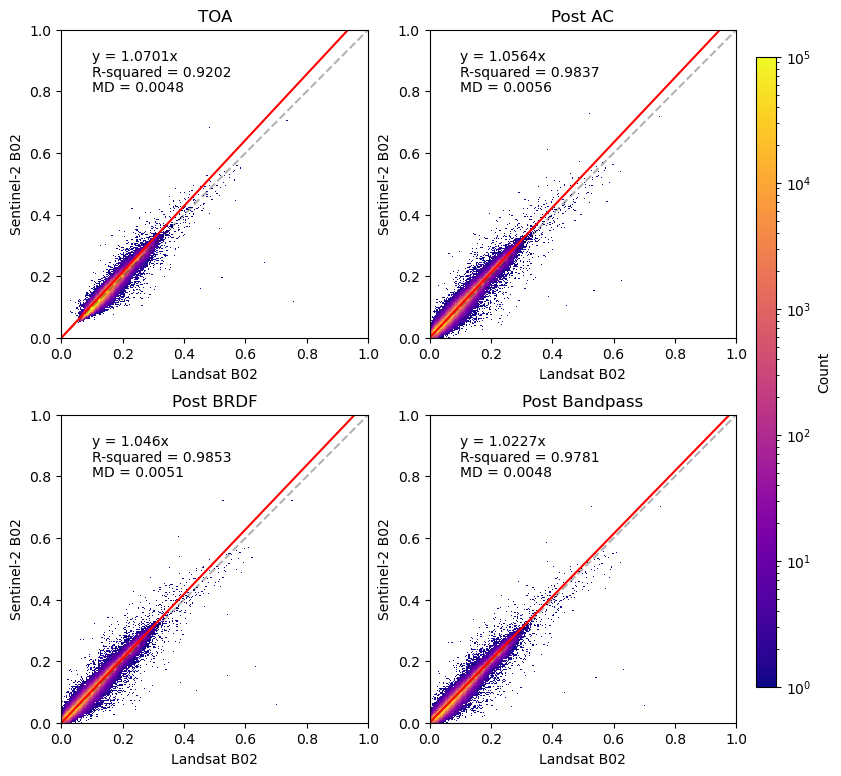

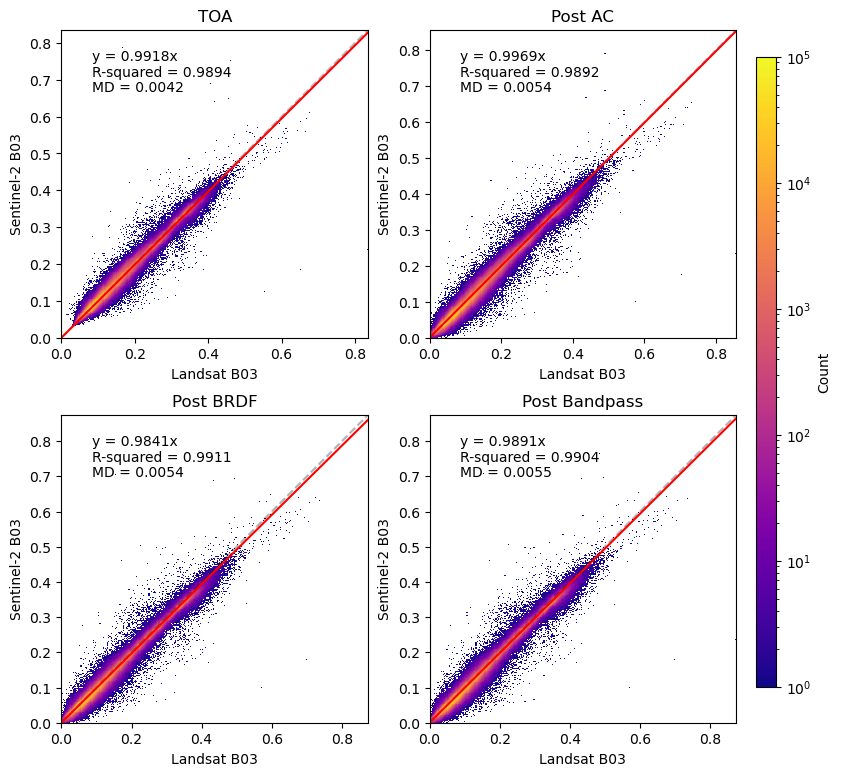

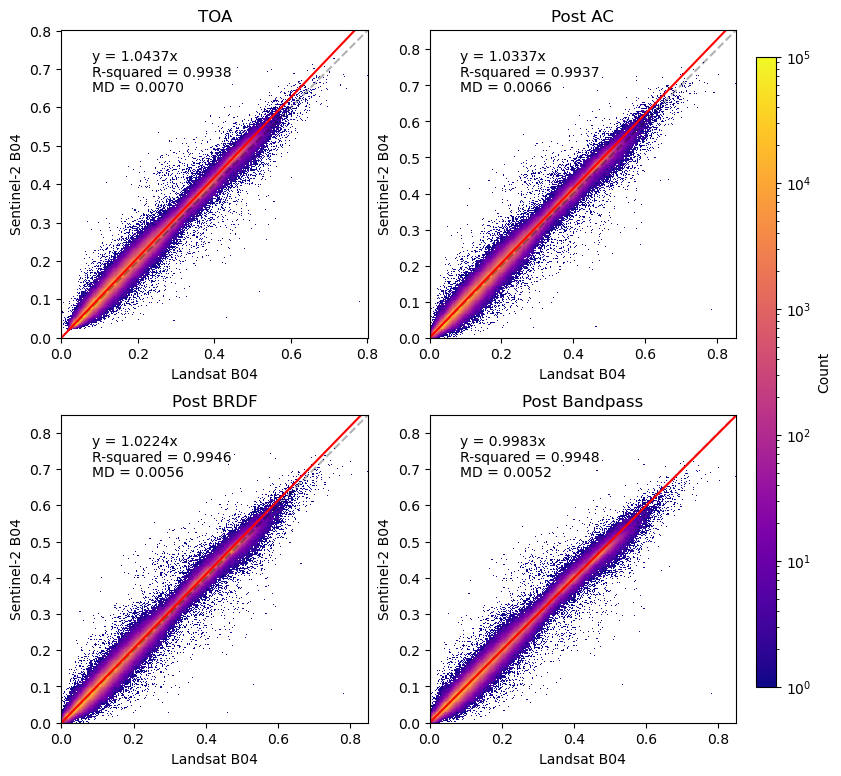

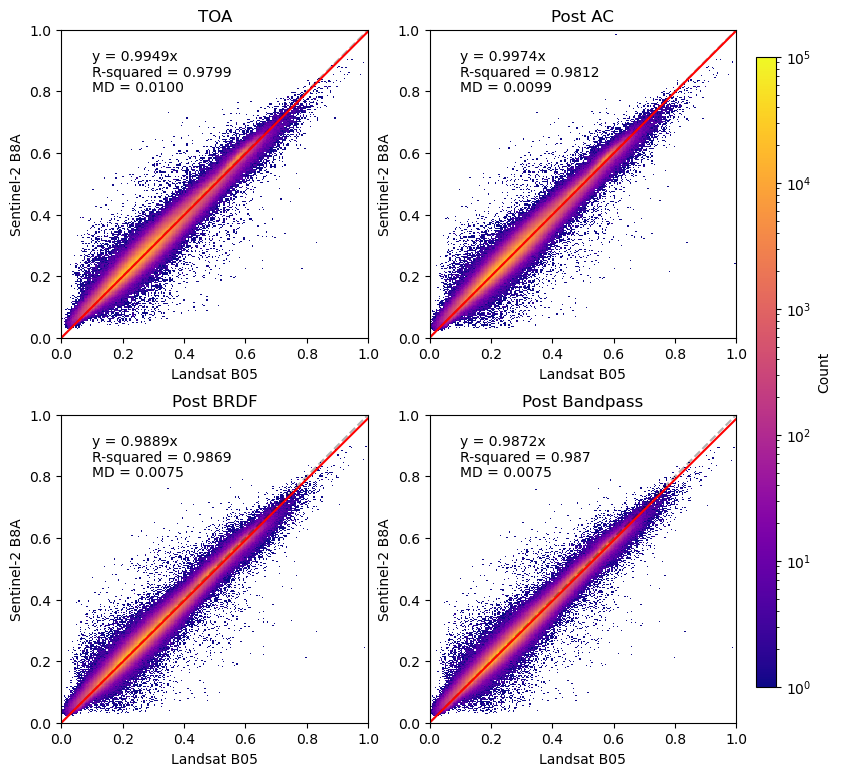

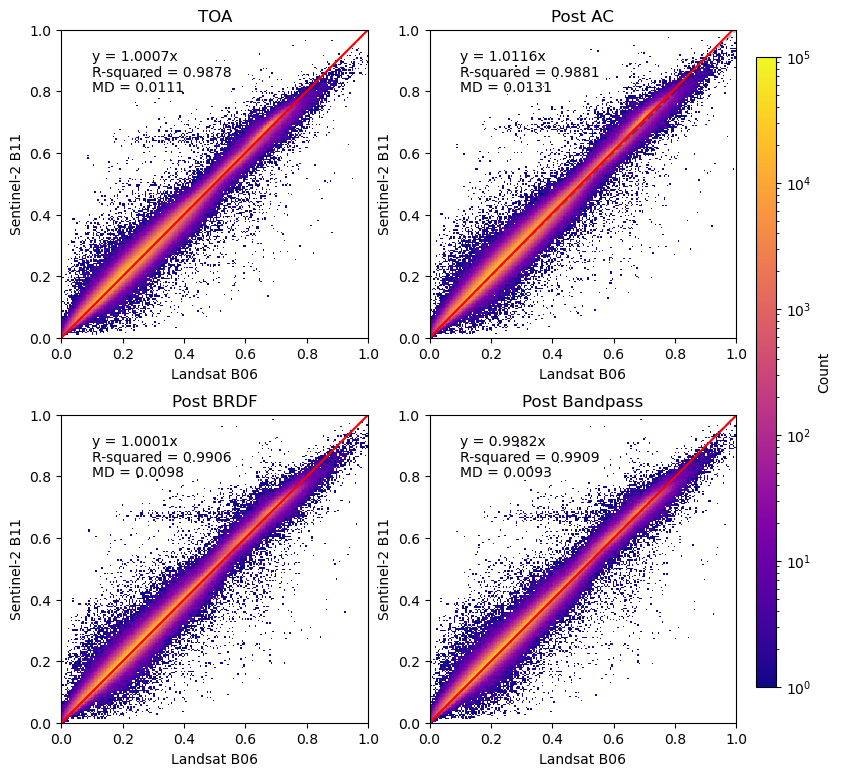

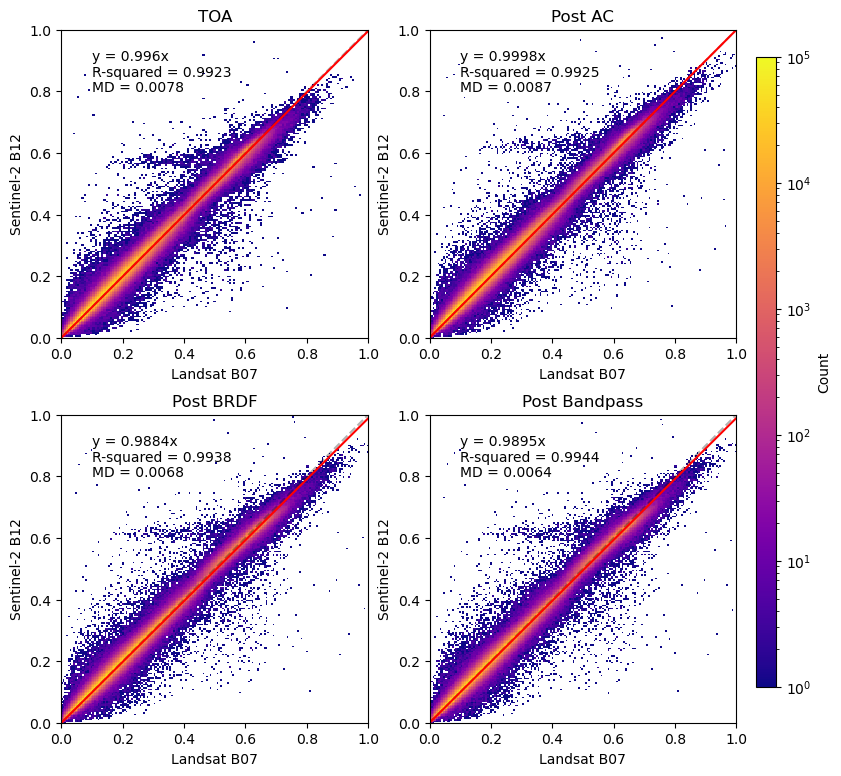

In [5]:
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'

snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)
date_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Date.npy"
date_arr = np.load(date_path)
tile_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Tile.npy"
tile_arr = np.load(tile_path)
tile_list = np.asarray([ID2TILE[t] for t in tile_arr])
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
comb_mask = snow_mask * water_mask * ~tile_mask

err_idx = 'mad'
reg_med='RMA'
n_row = 2
n_col = 2
for band in ["B02", "B03", "B04", "B05", "B06", "B07"]:
    fig, axs = plt.subplots(n_row, n_col, figsize=(10, 9))
    plt_step_scatter(fig, axs, comb_mask, band, reg_med=reg_med,err_idx=err_idx)

# MD by View azimuth difference

C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_19368\1418420683.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toa_mad_g = toa_df.groupby('Ang').apply(mad)
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_19368\1418420683.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ac_mad_g = ac_df.groupby('Ang').apply(mad)
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_19368\1418420683.py:50: DeprecationWarnin

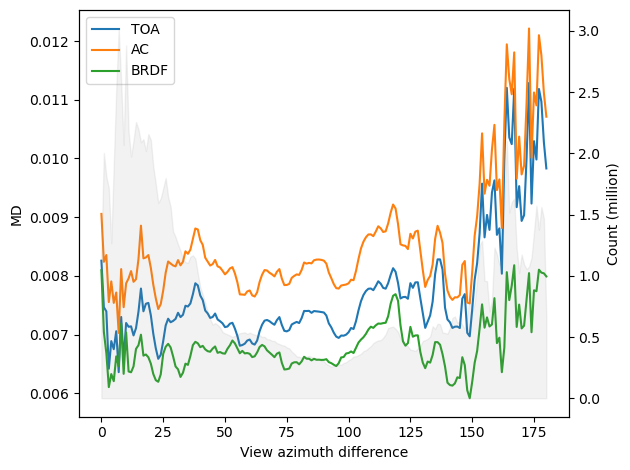

In [6]:
def mad(g):
    return pd.Series(dict(mad = np.mean(np.abs(g['L30'] - g['S30']))))

toa_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
comb_mask = snow_mask * water_mask * ~tile_mask 

f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_azimuth.npy'
ang_l_arr = np.load(f_ang)[comb_mask] * 0.01
f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_azimuth.npy'
ang_s_arr = np.load(f_ang)[comb_mask] * 0.01

# azimuth diff
ang_arr = np.abs(ang_l_arr - ang_s_arr)
ang_arr[ang_arr>180] = 360 - ang_arr[ang_arr>180]
ang_arr = np.round(ang_arr)
_, ang_cnt = np.unique(ang_arr, return_counts=True)

b = 'B07'
inter_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples'
toa_l_path = os.path.join(toa_dir, f"Merged_filtered_samp_L30_{b}.npy")
toa_l_arr = sr_scale * np.load(toa_l_path)[comb_mask]
toa_s_path = os.path.join(toa_dir, f"Merged_filtered_samp_S30_{L8_2_S2[b]}.npy")
toa_s_arr = sr_scale * np.load(toa_s_path)[comb_mask]
ac_l_path = os.path.join(inter_dir, f"Merged_filtered_samp_L30_sr_{b}.npy")
ac_l_arr = sr_scale * np.load(ac_l_path)[comb_mask]
ac_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_{L8_2_S2[b]}.npy")
ac_s_arr = sr_scale * np.load(ac_s_path)[comb_mask]
brdf_l_path = os.path.join(inter_dir, f"Merged_filtered_samp_L30_sr_nbar_{b}.npy")
brdf_l_arr = sr_scale * np.load(brdf_l_path)[comb_mask]
brdf_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_nbar_{L8_2_S2[b]}.npy")
brdf_s_arr = sr_scale * np.load(brdf_s_path)[comb_mask]
bp_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_nbar_{L8_2_S2[b]}.npy")
bp_s_arr = sr_scale * np.load(brdf_s_path)[comb_mask]

toa_df = pd.DataFrame({'Ang': ang_arr, 'L30': toa_l_arr, 'S30': toa_s_arr})
toa_mad_g = toa_df.groupby('Ang').apply(mad)
ac_df = pd.DataFrame({'Ang': ang_arr, 'L30': ac_l_arr, 'S30': ac_s_arr})
ac_mad_g = ac_df.groupby('Ang').apply(mad)
brdf_df = pd.DataFrame({'Ang': ang_arr, 'L30': brdf_l_arr, 'S30': brdf_s_arr})
brdf_mad_g = brdf_df.groupby('Ang').apply(mad)
bp_df = pd.DataFrame({'Ang': ang_arr, 'L30': brdf_l_arr, 'S30': bp_s_arr})
bp_mad_g = bp_df.groupby('Ang').apply(mad)

mad_g = pd.DataFrame({'Ang': toa_mad_g.index, 
                      'Count': ang_cnt / 1000000.0,
                      'TOA_MAD': toa_mad_g['mad'], 
                      'AC_MAD': ac_mad_g['mad'],
                     'BRDF_MAD': brdf_mad_g['mad'],
                     'Bandpass_MAD': bp_mad_g['mad']})
mad_g.set_index('Ang')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.fill_between(mad_g['Ang'], mad_g['Count'], label='Count (million)', color='grey', alpha=0.1)
ax2.set_ylabel('Count (million)')
ax1.plot(mad_g['Ang'], mad_g['TOA_MAD'], label='TOA')
ax1.plot(mad_g['Ang'], mad_g['AC_MAD'], label='AC')
ax1.plot(mad_g['Ang'], mad_g['BRDF_MAD'], label='BRDF')
ax1.set_xlabel('View azimuth difference')
ax1.set_ylabel('MD')
ax1.legend()
plt.tight_layout()

# Vegetation observation

In [7]:
# NDVI = (NIR - R) / (NIR + R)
def ndvi(red_arr, nir_arr):
    arr = (nir_arr - red_arr) / (nir_arr + red_arr)
    arr[(nir_arr + red_arr) == 0] = np.nan
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# EVI = 2.5 * ((NIR - R) / (NIR + 6 * R – 7.5 * B + 1))
def evi(blue_arr, red_arr, nir_arr):
    arr = 2.5 * ((nir_arr - red_arr) / (nir_arr + 6 * red_arr - 7.5 * blue_arr + 1))
    arr[(blue_arr < 0) | (blue_arr > 1)] = np.nan
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# SAVI = ((NIR - R) / (NIR + R + 0.5)) * (1.5)
def savi(red_arr, nir_arr):
    arr = ((nir_arr - red_arr) / (nir_arr + red_arr + 0.5)) * 1.5
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# MSAVI = (2 * NIR + 1 – sqrt ((2 * NIR + 1)^2 – 8 * (NIR - R))) / 2
def msavi(red_arr, nir_arr):
    arr = (2 * nir_arr + 1 - np.sqrt(np.square(2 * nir_arr + 1) - 8 * (nir_arr - red_arr))) / 2
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# NDMI = (NIR - SWIR1) / (NIR + SWIR1)
def ndmi(nir_arr, swir1_arr):
    arr = (nir_arr - swir1_arr) / (nir_arr + swir1_arr)
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    arr[(swir1_arr < 0) | (swir1_arr > 1)] = np.nan
    arr[(nir_arr + swir1_arr) == 0] = np.nan
    return arr

# NBR = (NIR - SWIR2) / (NIR + SWIR2)
def nbr(nir_arr, swir2_arr):
    arr = (nir_arr - swir2_arr) / (nir_arr + swir2_arr)
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    arr[(swir2_arr < 0) | (swir2_arr > 1)] = np.nan
    arr[(nir_arr + swir2_arr) == 0] = np.nan
    return arr

# NBR2 = (SWIR1 – SWIR2) / (SWIR1 + SWIR2)
def nbr2(swir1_arr, swir2_arr):
    arr = (swir1_arr - swir2_arr) / (swir1_arr + swir2_arr)
    arr[(swir1_arr < 0) | (swir1_arr > 1)] = np.nan
    arr[(swir2_arr < 0) | (swir2_arr > 1)] = np.nan
    arr[(swir1_arr + swir2_arr) == 0] = np.nan
    return arr

# TVI = (120*(B5-B3)-200*(B4-B3))/2  - Triangular Vegetation Index
def tvi(green_arr, red_arr, nir_arr):
    arr = (120*(nir_arr-green_arr)-200*(red_arr-green_arr))/2
    arr[(green_arr < 0) | (green_arr > 1)] = np.nan
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# NDWI = (GREEN - NIR) / (GREEN + NIR)
def ndwi(green_arr, nir_arr):
    arr = (green_arr - nir_arr) / (green_arr + nir_arr)
    arr[(green_arr < 0) | (green_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    arr[(green_arr + nir_arr) == 0] = np.nan
    return arr


def cal_vi(work_dir, vi_name, res, sample_mask):
    ## Calculate vegetation indexes for the final results of intermediate samples
    if vi_name == 'NDVI':
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = ndvi(red_l, nir_l)
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = ndvi(red_s, nir_s)
    elif vi_name == 'EVI':
        blue_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Blue']}.npy"))[sample_mask]#[sample_idx]
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = evi(blue_l, red_l, nir_l)
        blue_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Blue']}.npy"))[sample_mask]#[sample_idx]
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = evi(blue_s, red_s, nir_s)
    elif vi_name == 'SAVI':
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = savi(red_l, nir_l)
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = savi(red_s, nir_s)
    elif vi_name == 'MSAVI':
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = msavi(red_l, nir_l)
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = msavi(red_s, nir_s)
    elif vi_name == 'NDMI':
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        swir1_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['SWIR1']}.npy"))[sample_mask]#[sample_idx]
        l_arr = ndmi(nir_l, swir1_l)
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        swir1_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['SWIR1']}.npy"))[sample_mask]#[sample_idx]
        s_arr = ndmi(nir_s, swir1_s)
    elif vi_name == 'NBR':
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        swir2_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['SWIR2']}.npy"))[sample_mask]#[sample_idx]
        l_arr = nbr(nir_l, swir2_l)
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        swir2_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['SWIR2']}.npy"))[sample_mask]#[sample_idx]
        s_arr = nbr(nir_s, swir2_s)
    elif vi_name == 'NBR2':
        swir1_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['SWIR1']}.npy"))[sample_mask]#[sample_idx]
        swir2_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['SWIR2']}.npy"))[sample_mask]#[sample_idx]
        l_arr = nbr2(swir1_l, swir2_l)
        swir1_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['SWIR1']}.npy"))[sample_mask]#[sample_idx]
        swir2_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['SWIR2']}.npy"))[sample_mask]#[sample_idx]
        s_arr = nbr2(swir1_s, swir2_s)
    elif vi_name == 'TVI':
        green_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Green']}.npy"))[sample_mask]#[sample_idx]
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = tvi(green_l, red_l, nir_l)
        green_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Green']}.npy"))[sample_mask]#[sample_idx]
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = tvi(green_s, red_s, nir_s)
    elif  vi_name == 'NDWI':
        green_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Green']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = ndwi(green_l, nir_l)
        green_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Green']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = ndwi(green_s, nir_s)
    else:
        print('VI not implemented.')
        return None, None
    return l_arr, s_arr

In [8]:
vi_range = {'NDVI': [-1, 1], 'EVI': [-1, 1], 'SAVI': [-1, 1], 'MSAVI': [-1, 1],
           'NDMI': [-1, 1], 'NDWI': [-1, 1], 'NBR': [-1, 1], 'NBR2': [-1, 1], 'TVI': [-1, 25], 'TVI2': [0, 1.2]}
def plt_vi_scatter(fig, axs, sample_dir, sample_mask, ind_list, reg_med='OLS', err_idx='rmsd'):
    sub_pop = 0.1
    marker_size = 0.5
    for i, b in enumerate(ind_list):
        l_arr, s_arr = cal_vi(sample_dir, b, "Post Bandpass", sample_mask) #Post Bandpass
        
        water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
        water_mask = np.load(water_dir)#.astype(bool)
        l_arr = l_arr[water_mask[sample_mask]]# * mask_ndvi
        s_arr = s_arr[water_mask[sample_mask]]# * mask_ndvi
        valid_mask = (l_arr>vi_range[b][0]) * (l_arr<vi_range[b][1]) * (s_arr>vi_range[b][0]) * (s_arr<vi_range[b][1])
        l_arr = l_arr[valid_mask]
        s_arr = s_arr[valid_mask]
        if err_idx=='rmsd':
            msd = np.square(np.subtract(l_arr, s_arr)).mean()
            rmsd = math.sqrt(msd)
        elif err_idx=='mad':
            mad = np.mean(np.abs(l_arr - s_arr))
        else:
            print('err_idx can only be rmsd or mad.')

        if reg_med == 'OLS':
            model = LinearRegression(fit_intercept=False)
            model.fit(l_arr.reshape(-1, 1), s_arr)
            model_slope = model.coef_[0]
            model_inter = model.intercept_
            y_pred = model.predict(l_arr.reshape(-1, 1))
        elif reg_med == 'RMA':
            model_dict = rma_regression(l_arr, s_arr, need_intercept=False)
            model_slope = model_dict[0]
            model_inter = model_dict[1]
            y_pred = model_slope * l_arr + model_inter
        else:
            print('reg_med can only be OLS or RMA.')

        r2 = r2_score(s_arr, y_pred)
        
        sample_idx = (np.random.rand(l_arr.shape[0]) < sub_pop)# * (l_arr < 1) * (s_arr < 1)
        l_arr = l_arr[sample_idx]
        s_arr = s_arr[sample_idx]

        max_val = max(np.percentile(l_arr, 99.99), np.percentile(s_arr, 99.99))
        min_val = max(np.percentile(l_arr, 0.01), np.percentile(s_arr, 0.01))
        if min_val > 0:
            x_ann = min_val * 1.3
        else:
            x_ann = min_val * 0.7

        counts, xedges, yedges, im = axs[i//n_col, i%n_col].hist2d(l_arr, s_arr, bins=300, range=[[min_val,max_val],[min_val,max_val]], cmin=1, norm=colors.LogNorm(vmin=1,vmax=1e+4), cmap = cm.plasma)
        axs[i//n_col, i%n_col].set_title(b)

        axs[i//n_col, i%n_col].set_xlim((min_val, max_val))
        axs[i//n_col, i%n_col].set_ylim((min_val, max_val))
        ticks = axs[i//n_col, i%n_col].get_yticks()
        if (ticks[0] < 0) & (ticks[0] < min_val):
            ticks = ticks[1:]
        if ticks[-1] > max_val:
            ticks = ticks[:-1]
        axs[i//n_col, i%n_col].set_xticks(ticks)
        axs[i//n_col, i%n_col].set_yticks(ticks)
        axs[i//n_col, i%n_col].set_xlabel(f'Landsat {b}')
        axs[i//n_col, i%n_col].set_ylabel(f'Sentinel-2 {b}')
        axs[i//n_col, i%n_col].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
        xseq = np.linspace(min_val, max_val, num=10)
        if err_idx == 'rmsd':
            axs[i//n_col, i%n_col].annotate(f"RMSD = {np.round(rmsd, 4):.4f}", xy=(0.05, 0.8), xycoords='axes  fraction')
        elif err_idx == 'mad':
            axs[i//n_col, i%n_col].annotate(f"MD = {np.round(mad, 4):.4f}", xy=(0.05, 0.8), xycoords='axes  fraction') #xy=(x_ann, max_val * 0.79)
        else:
            print('err_idx can only be rmsd or mad.')
        if reg_med == 'OLS':
            axs[i//n_col, i%n_col].plot(xseq, model.predict(xseq.reshape(-1, 1)), color="r")
        elif reg_med == 'RMA':
            axs[i//n_col, i%n_col].plot(xseq, model_slope * xseq + model_inter, color="r")
        else:
            print('reg_med can only be OLS or RMA.')
        if model_inter >= 0:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(0.05, 0.95), xycoords='axes  fraction') #+{np.round(model.intercept_, 4)}
        else:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(0.05, 0.95), xycoords='axes  fraction') #{np.round(model.intercept_, 4)}
        axs[i//n_col, i%n_col].annotate(f"R-squared = {np.round(r2, 4)}", xy=(0.05, 0.87), xycoords='axes  fraction')
        
    fig.subplots_adjust(right=0.8, wspace=0.25, hspace=0.3)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.colorbar(im, cax=cbar_ax).set_label('Count')

Total number of valid samples pairs:  160253969


C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_19368\966600550.py:3: RuntimeWarning: divide by zero encountered in divide
  arr = (nir_arr - red_arr) / (nir_arr + red_arr)
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_19368\966600550.py:26: RuntimeWarning: invalid value encountered in sqrt
  arr = (2 * nir_arr + 1 - np.sqrt(np.square(2 * nir_arr + 1) - 8 * (nir_arr - red_arr))) / 2
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_19368\966600550.py:41: RuntimeWarning: divide by zero encountered in divide
  arr = (nir_arr - swir2_arr) / (nir_arr + swir2_arr)
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_19368\966600550.py:49: RuntimeWarning: divide by zero encountered in divide
  arr = (swir1_arr - swir2_arr) / (swir1_arr + swir2_arr)
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_19368\966600550.py:49: RuntimeWarning: invalid value encountered in divide
  arr = (swir1_arr - swir2_arr) / (swir1_arr + swir2_arr)


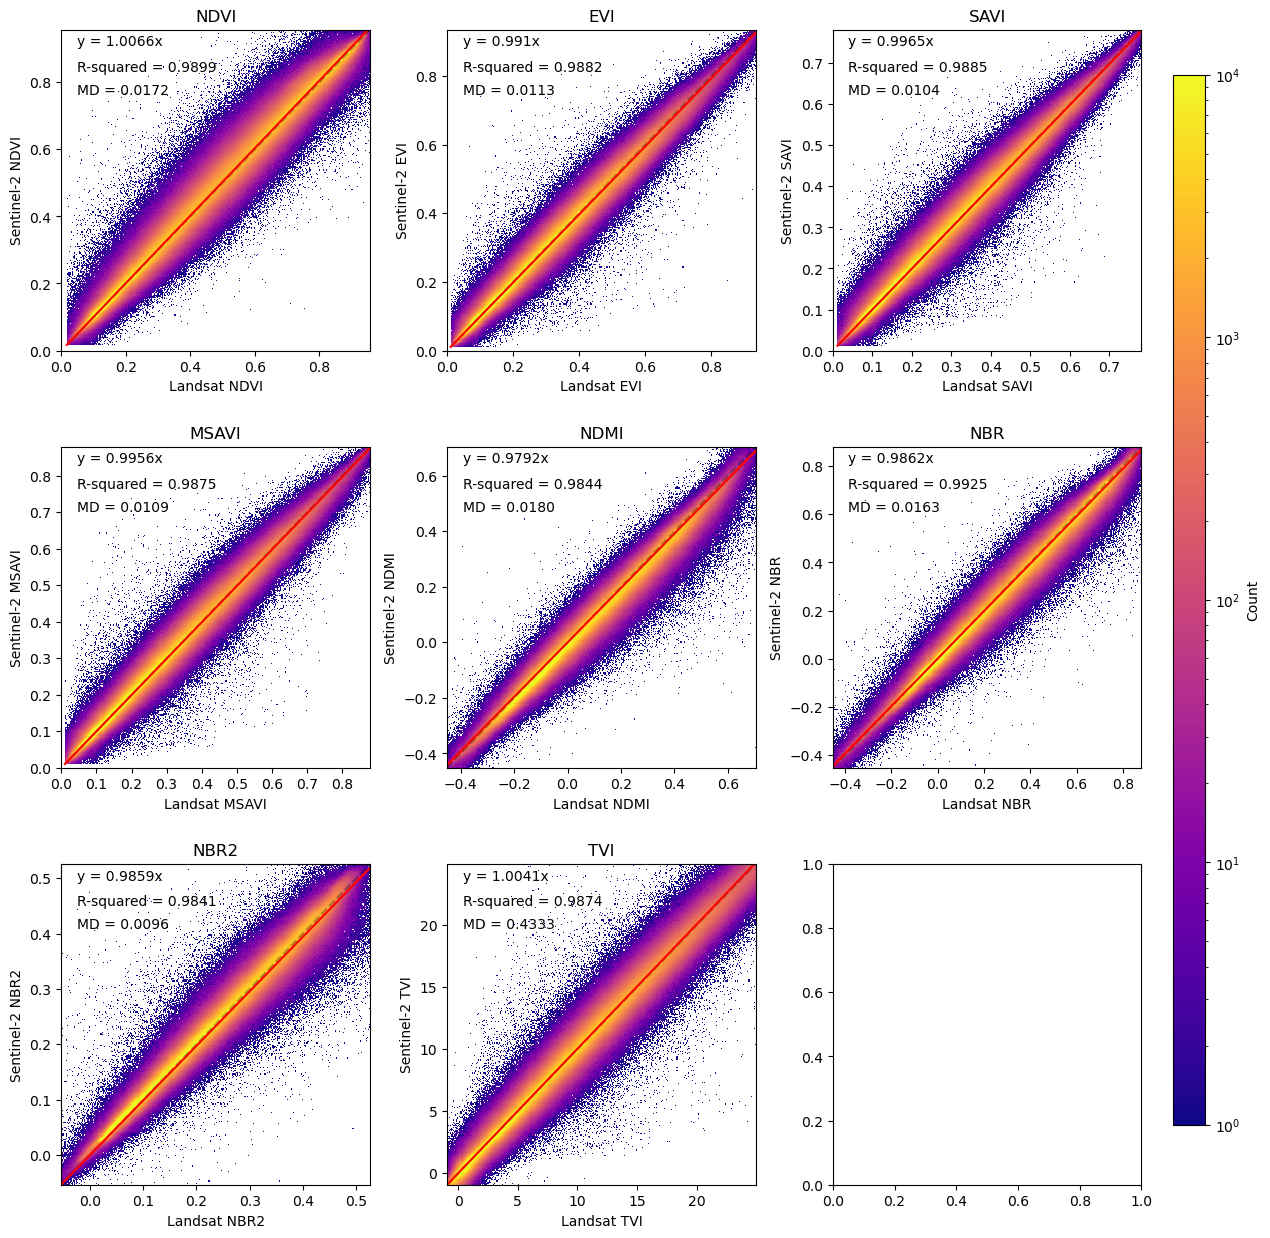

In [9]:
indexes = ["NDVI", "EVI", "SAVI", "MSAVI", "NDMI", "NBR", "NBR2", "TVI"]# , "NDWI"

sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
date_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Date.npy"
date_arr = np.load(date_path)
tile_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Tile.npy"
tile_arr = np.load(tile_path)
tile_list = np.asarray([ID2TILE[t] for t in tile_arr])
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
comb_mask = snow_mask * water_mask * ~tile_mask #toa_mask * 
print("Total number of valid samples pairs: ", np.sum(comb_mask))


err_idx='mad'
n_row = 3
n_col = 3
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(16, 15))
plt_vi_scatter(fig, axs, sample_dir, comb_mask, indexes, reg_med='RMA', err_idx=err_idx)